# Testing Algorithms for Paper

## Name: Victor Agaba

## Date: 2024-04-11

***

In [27]:
import sys, os, importlib
package_path = os.path.abspath('..')    
if package_path not in sys.path:
    sys.path.append(package_path)
from package import functions as fn
from package import model as sm
from package import optimizer as opt
from package import plots
import numpy as np
from obspy.taup import TauPyModel

In [ ]:
from obspy.clients.fdsn import Client
from obspy import UTCDateTime

import os

# I want instrument response from MBAR station
# Make sure Ao is correct

# Define paths and parameters
path = os.getcwd()
dst = os.path.join(path, 'Stationxml/')
os.makedirs(dst, exist_ok=True)

client = Client("IRIS")
netsclts = {"II": "IRIS"}
starttime = UTCDateTime(2001, 1, 1, 0, 0, 0)
endtime = UTCDateTime(2020, 12, 12, 23, 59, 59)

# Loop through networks and retrieve metadata
for net in list(netsclts.keys()):
    client = Client(netsclts[net])
    inventory = client.get_stations(
        starttime=starttime,
        endtime=endtime,
        network=net,
        sta="MBAR",
        loc="00",
        channel="*",
        level="response"
    )
    # inventory.write(dst + f"metadata.{net}.xml", format="STATIONXML")
    # print(f"Metadata for {net} written to {dst}")

    # Plot instrument response for displacement
    for network in inventory:
        # print('yes1')
        # print(network)
        # print(type(network))
        for station in network:
            # print('yes2')
            # print(station)
            # print(type(station))
            for channel in station:
                # print('yes3')
                # print(type(channel))
                # print(channel.code)
                # print(channel.calibration_units)
                # print every attribute of channel
                for attr in dir(channel):
                    print(attr)
                # break
                if channel in ["BH1", "BH2", "BHZ"]:
                    print('yes')
                    response = channel.response
                    if response:
                        print(f"Plotting instrument response for {channel.code}")
                        response.plot(0.001, output="DISP")  # Frequency 0.001 Hz



***
#### Synthetic Parameters
***

Seed: 1161
Original params:  [355.28065686  74.76143268  82.6056681 ]


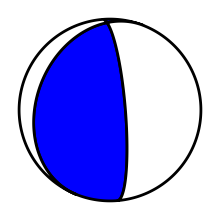

[45.74277419944782, 49.94361025435123]


In [28]:
seed = np.random.randint(0, 2024)
np.random.seed(seed)
print(f'Seed: {seed}')

# np.random.seed(2024)
# np.random.seed(1513)
# np.random.seed(555)

# # BUG plot_iterates_2D (off by 1)
# np.random.seed(560)

# create random array for t, normalised to 1
t = fn.unit_vec(np.random.rand(3))

# create random array for p, normalised to 1
direc = fn.unit_vec(np.random.rand(3))
p = fn.starting_direc(t, direc)

# get truen params for synthetic test
true_params = fn.tp2sdr(t, p, True)[0]
print('Original params: ', true_params)

# plot corresponding beachball
beachball = fn.beachball(true_params)

# set up parameters for inversion
model = TauPyModel(model='ak135')  # velocity model
hdepth = 15  # km - assumed quake depth
epdist = 10  # degrees - epicentral distance
azimuth = 200  # degrees - azimuth of seismometer
arrivals = model.get_travel_times(source_depth_in_km=hdepth,
                        distance_in_degree=epdist, phase_list=['P', 'S'])
takeoff_angles = [a.takeoff_angle for a in arrivals]
print(takeoff_angles)
velocities = np.array([5.8000, 3.4600])

# NOTE: Be aware of more than one P/S arrival
# Plot beachball set: grid + ordered overlay
# Example events (Paula) --- Mars later
# Laplacians (finite differences)
# Moment tensor
# Alt cost function --- later

***
#### Hybrid Inversion
***

In [29]:
importlib.reload(fn)
importlib.reload(sm)
importlib.reload(opt)
importlib.reload(plots)

# initialize model
inv_model = sm.SeismicModel(np.deg2rad(azimuth), takeoff_angles, velocities)
best_fit = inv_model(np.deg2rad(true_params), set_Ao=True)

# tune hyperparameters
config = opt.get_config()

# initialize random hybrid search: many runs
num_runs = 30
starts = fn.random_params(num_runs)

# # initialize systematic hybrid search: debugging
# step_size = 30
# starts = fn.systematic_params(step_size)
# num_runs = len(starts)

# multi-start optimization
inv_model.reset()
print_every = 10

for index, start in enumerate(starts):
    if print_every > 0 and index % print_every == 0:
        print(f'Run {index} of {num_runs}')
    opt.minimize(inv_model, config, start)
    
print(f'Convergence rate: {inv_model.get_convergence_rate():.0f}%')

Run 0 of 30
Run 10 of 30
Run 20 of 30
Convergence rate: 97%


Axis: T
Optimal parameters: [29.20887226 37.75633677 10.7634626 ]
Search error: 0.28546877067142556 degrees


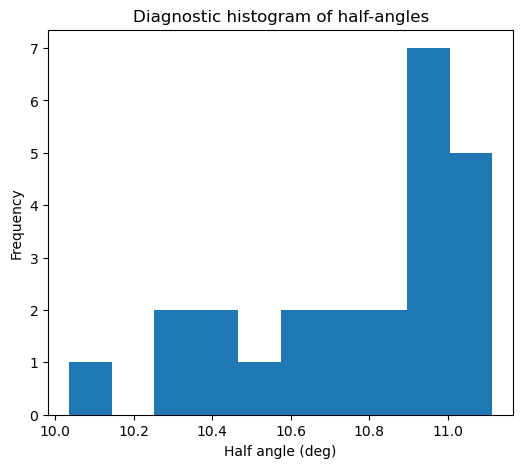

In [30]:
params, error, position = inv_model.get_optimal_parameterization()
name = 'T' if position == 0 else 'P'

print(f'Axis: {name}')
print(f'Optimal parameters: {np.rad2deg(params)}')
print(f'Search error: {np.rad2deg(error)} degrees')

plots.half_angles(inv_model, bins=10)

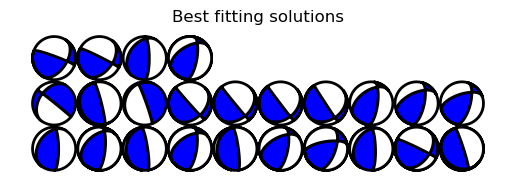

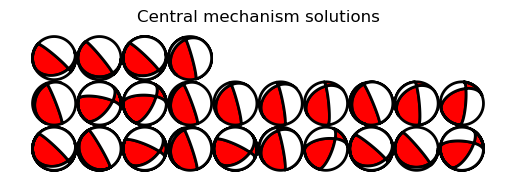

In [31]:
# beachball plots
plots.beachballs(inv_model, central=False, order_by='strike')
plots.beachballs(inv_model, central=True, order_by='strike')

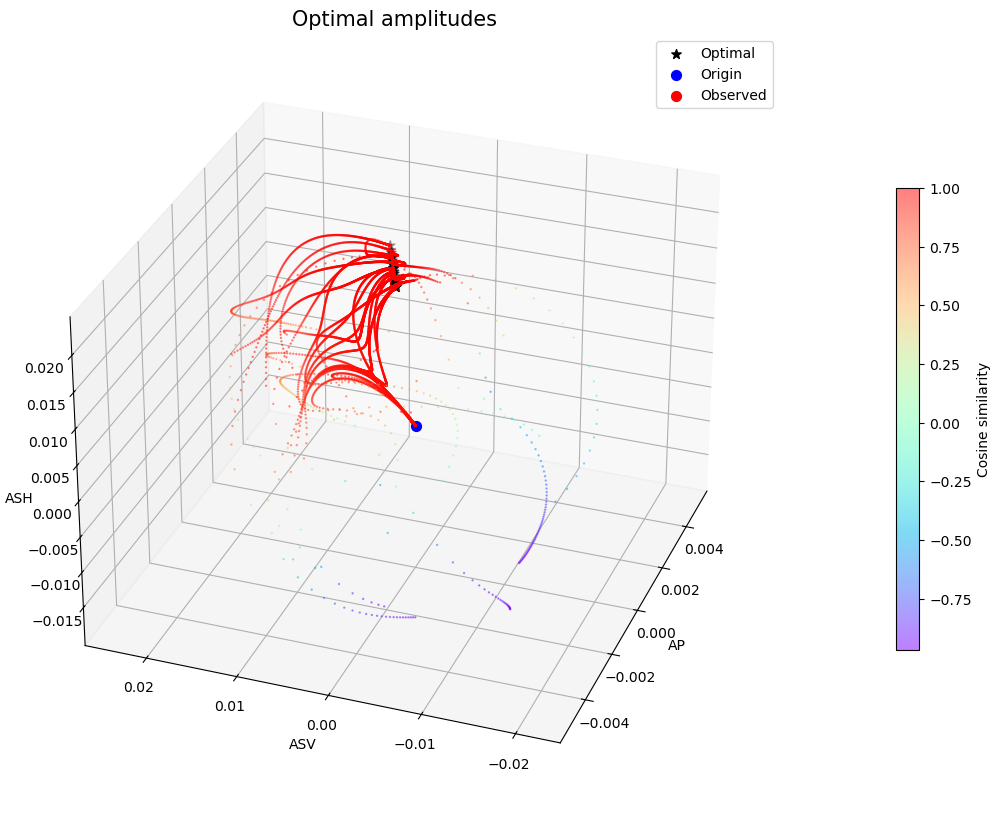

In [32]:
# amplitude plot
# TODO: include marker at origin
plots.amplitudes(inv_model, azim=200, elev=30, s=50, alpha=0.5, iterates=True)

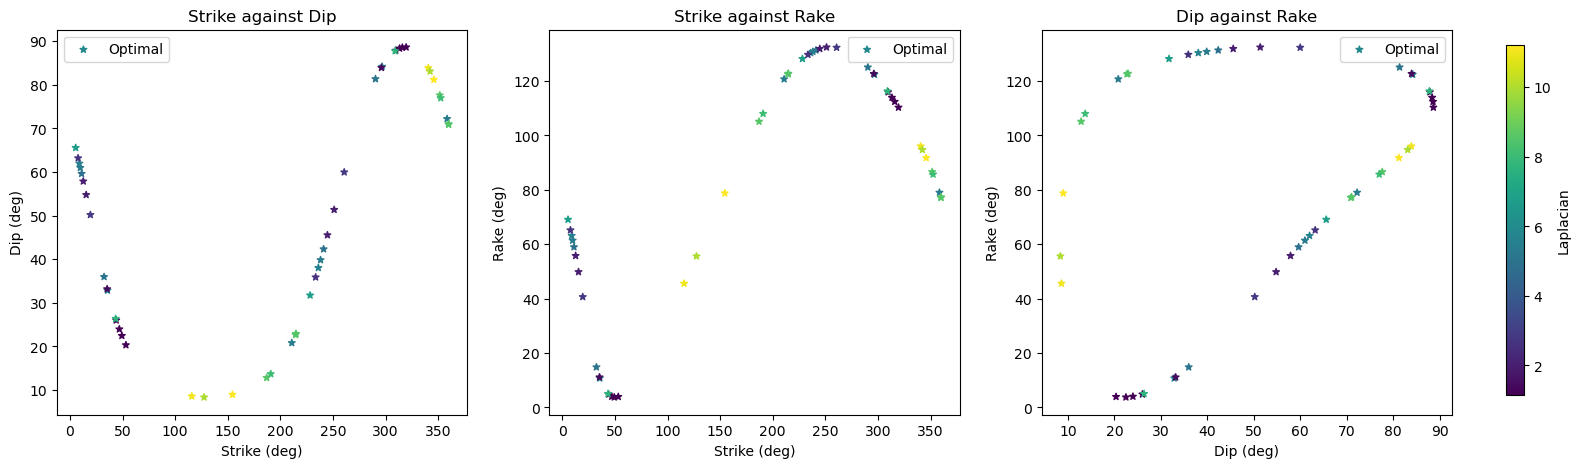

In [33]:
# iterate plot - sdr space
plots.iterates_2D(inv_model, s=25, optimal=True, index=2, cmap='viridis')
# plots.iterates_2D(s=1, optimal=False, index=0)
# plots.iterates_2D(s=1, optimal=False, index=1)

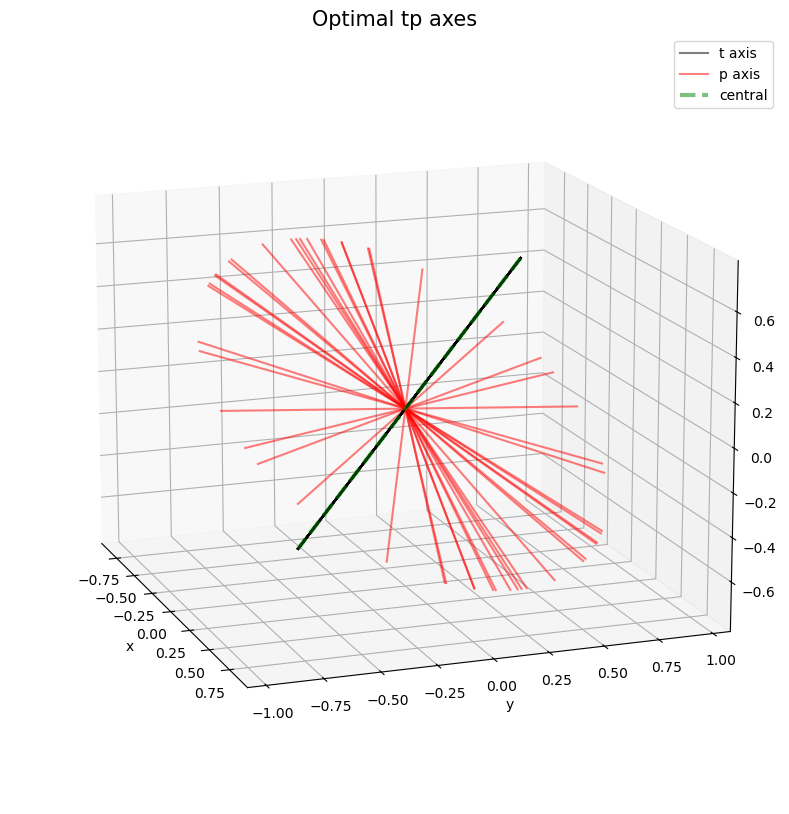

In [34]:
# optimal plot - tp space, collapse to central
plots.tp_axes(inv_model, azim=-20, elev=15, half=False, central=True)

***
#### Uncertainty Propagation
***

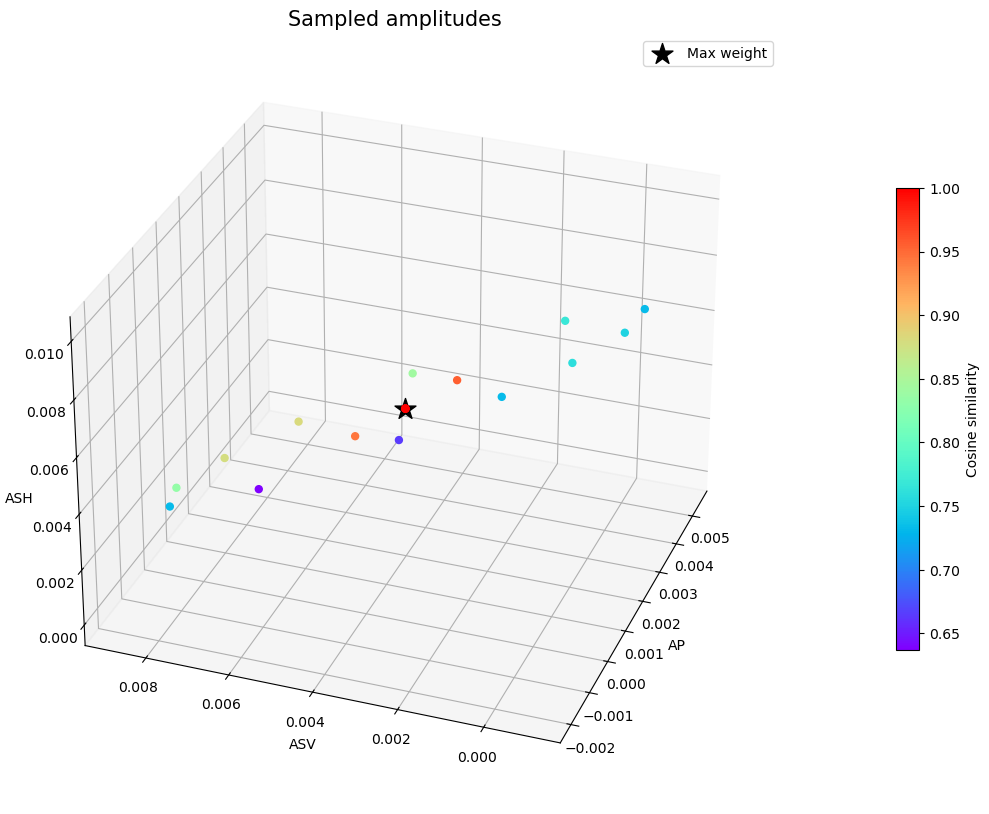

In [35]:
# dd, num_samples = 15, 25
dd, num_samples = 30, 15  # debugging
inv_model.init_uncertainty()
inv_model.sample_amplitudes(dd, num_samples)
plots.sampled_amplitudes(inv_model, cmap='rainbow', s=25, azimuth=200, elevation=30)

In [36]:
num_runs, print_every = 30, 0
inv_model.monte_carlo(dd, num_samples, num_runs, print_every)

Sample 0 of 19
Sample 1 of 19
Sample 2 of 19
Sample 3 of 19
Sample 4 of 19
Sample 5 of 19
Sample 6 of 19
Sample 7 of 19
Sample 8 of 19
Sample 9 of 19
Sample 10 of 19
Sample 11 of 19
Sample 12 of 19
Sample 13 of 19
Sample 14 of 19
Sample 15 of 19
Sample 16 of 19
Sample 17 of 19
Sample 18 of 19


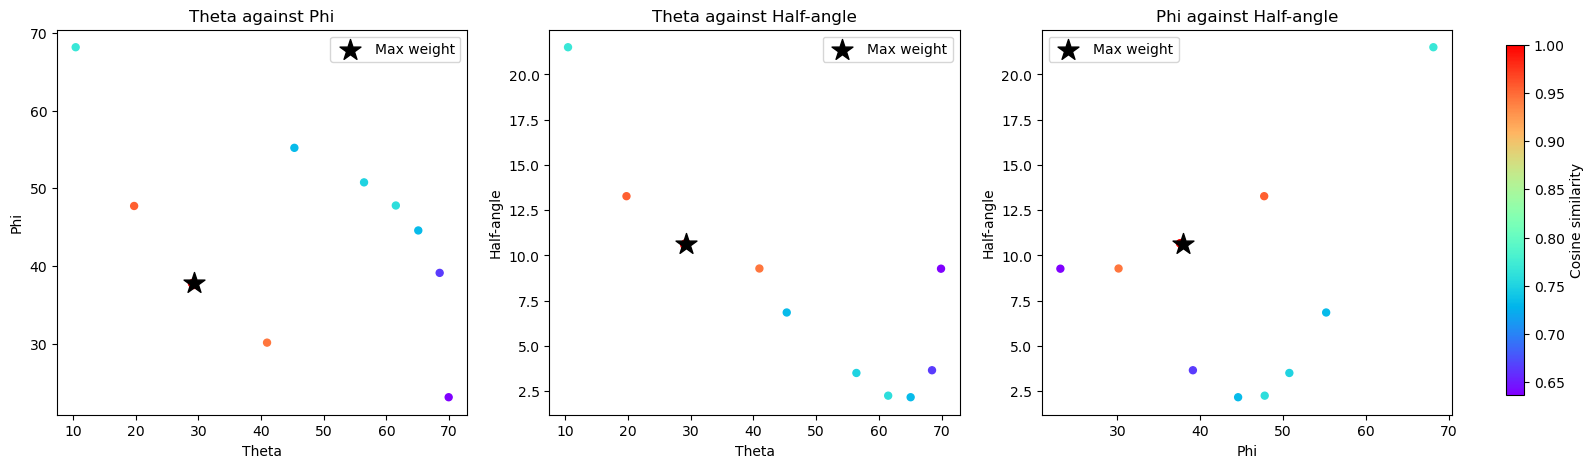

In [37]:
# monte carlo plot - cone space
error_threshold = 5
inv_model.post_filter(threshold=error_threshold)
plots.uncertainty_2D(inv_model, s=25, scale=0)
# plots.uncertainty_3D(elev=30, azim=45, s=25)

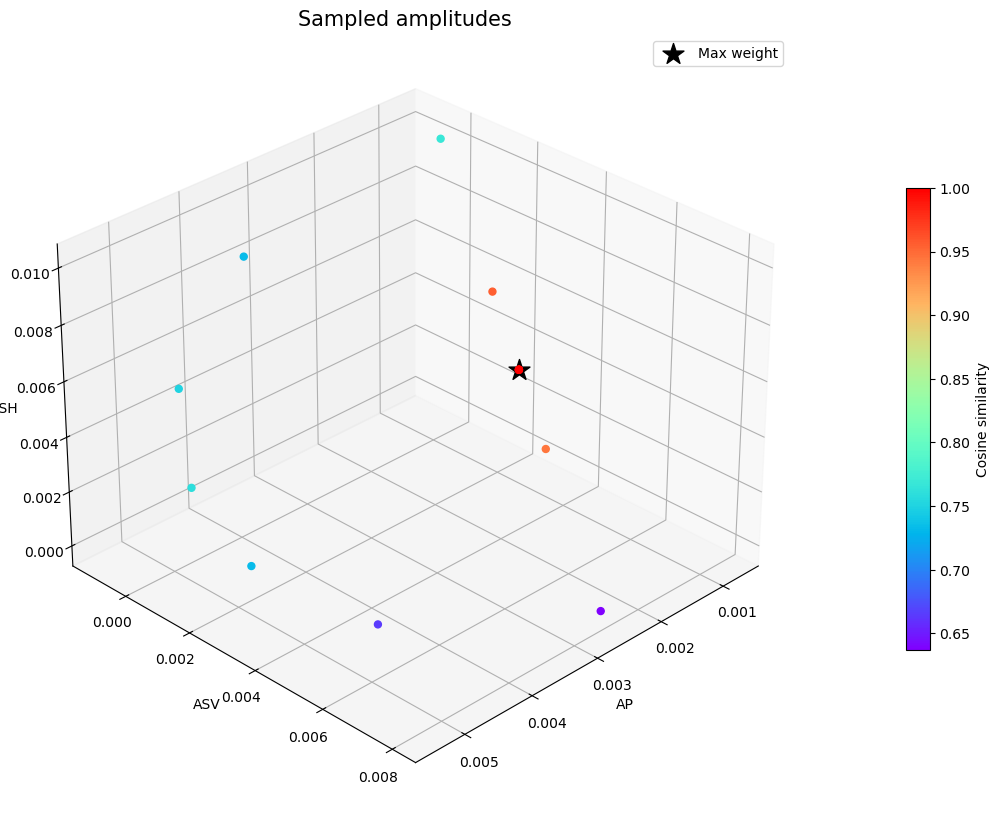

In [38]:
plots.sampled_amplitudes(inv_model, cmap='rainbow', s=25)

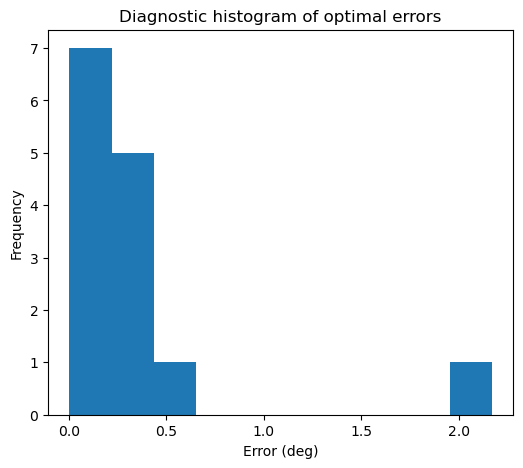

In [39]:
# diagnostic plot of monte carlo errors
plots.optimal_errors(inv_model, bins=10)